Plot LSLA effects on the baseline trajectories/categorizations

In [1]:
import  plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pickle
from collections import OrderedDict
from math import pi
import brewer2mpl

# styles = plot_style.create() # get the plotting styles
# styles['plot_type'] = 'paper'
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-white')
# plt.style.use(styles['paper'])

In [2]:
exp_name = 'trajectories_test'
lsla_exp_name = ''
cats = ['S+E+','S+E-','S-E+','S-E-']

In [3]:
# import the model data
all_mods = pickle.load(open('../../outputs/{}/{}lsla_all_models.pkl'.format(exp_name, lsla_exp_name), 'rb'))

In [4]:
scenarios = list(all_mods.keys())
mod_names = list(all_mods[scenarios[0]].keys())
outputs = list(all_mods[scenarios[0]][mod_names[0]].keys())
nreps = len(all_mods[scenarios[0]][mod_names[0]][outputs[0]])
outputs

['has_livestock', 'sufficient_income', 'som', 'grass']

In [5]:
all_mods[scenarios[4]][mod_names[2]][outputs[3]][0]

array([0.99971852, 1.07561577, 1.15363814, 1.21435593, 1.26535888,
       1.30452186, 1.32182643, 1.35248892, 1.36918631, 1.383455  ,
       1.39529497, 1.40409905, 1.41472466, 1.42170721, 1.4247431 ,
       1.42868975, 1.43081488, 1.43233282, 1.4302077 , 1.43172564,
       1.42565386, 1.3722222 , 1.39013395, 1.4025811 , 1.40318828,
       1.41684978, 1.39802727, 1.40865288, 1.41351031, 1.42018926,
       1.42717181, 1.42960052, 1.4302077 , 1.42110003, 1.37282938,
       1.38466935, 1.39559856, 1.40652776, 1.41351031, 1.41229595,
       1.41715337, 1.40926006, 1.39043754, 1.36281095, 1.38466935,
       1.39256267, 1.39893803, 1.39286625, 1.40561699, 1.38132987,
       1.39286625])

In [6]:
# format the data
# average outputs over ALL models and replications
formatted_data = OrderedDict()
for s, sc in enumerate(scenarios):
    formatted_data[sc] = OrderedDict()
    for c, cat in enumerate(cats):
        formatted_data[sc][cat] = {}
        for o, output in enumerate(outputs):
            # loop over all models in this category
            mod_data = []
            for mod_name, mi in all_mods[sc].items():
                if mod_name[0]==str(c):
                    mod_data.append(mi[output]) # append if it's the correct category
            
            axx = (0,1) if output=='grass' else (0,1,3) # (mod,rep,year,agent)->(year) (grass has no agent)
            formatted_data[sc][cat][output] = np.mean(np.array(mod_data), axis=axx) # dimension --> (year)

## Trajectories averaged over all models

In [7]:
formatted_data[scenarios[2]][cats[1]][outputs[0]]

array([0.844475, 0.846825, 0.817325, 0.792225, 0.7674  , 0.751725,
       0.7767  , 0.770325, 0.78445 , 0.777075, 0.770725, 0.76185 ,
       0.76325 , 0.7635  , 0.758525, 0.7515  , 0.7635  , 0.74885 ,
       0.751225, 0.732625, 0.700725, 0.72875 , 0.733725, 0.735925,
       0.73065 , 0.696425, 0.7085  , 0.692275, 0.70715 , 0.687075,
       0.699875, 0.6891  , 0.647175, 0.659   , 0.68215 , 0.680175,
       0.681325, 0.677025, 0.67165 , 0.684175, 0.684075, 0.688625,
       0.669275, 0.681575, 0.6853  , 0.677625, 0.67895 , 0.6895  ,
       0.592075, 0.663025])

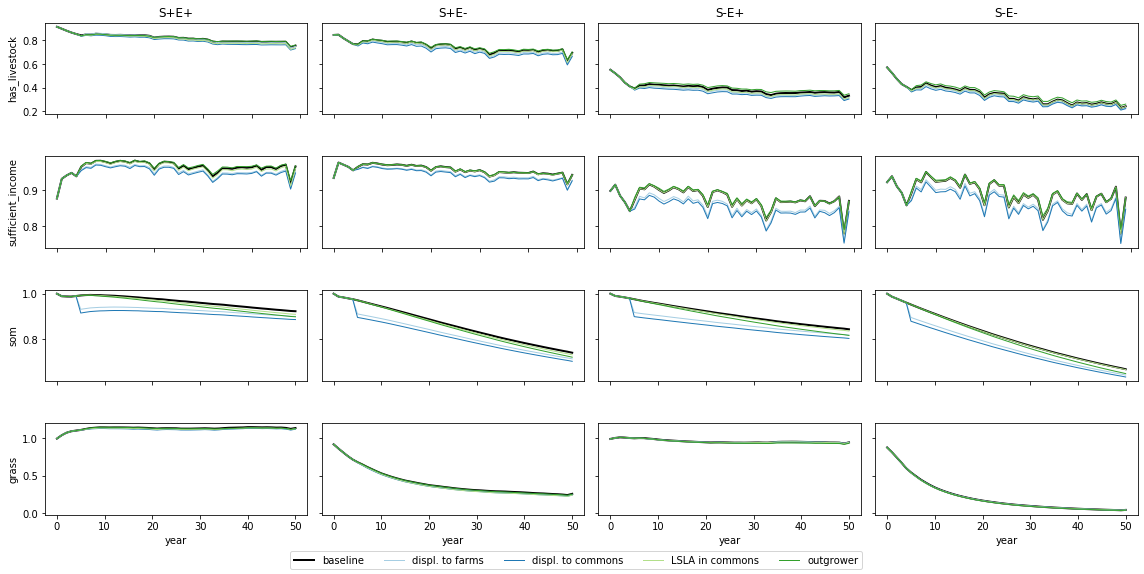

In [26]:
colors = brewer2mpl.get_map('Paired', 'Qualitative', len(scenarios)-1).mpl_colors
fig, ax_all = plt.subplots(5,4,figsize=(16,8),gridspec_kw={'height_ratios':[1,1,1,1,0.05]},
                          sharey='row')
axs = ax_all[:-1]
[axi.remove() for axi in ax_all[-1]]
fax = axs.flatten()
for c, cat in enumerate(cats):
    for o, output in enumerate(outputs):
        color_ix = 0
        for s, sc in enumerate(scenarios):
            if sc=='baseline':
                color='k'
                lw=2
            else:
                color = colors[color_ix]
                color_ix += 1
                lw=1
                
            axs[o,c].plot(formatted_data[sc][cat][output], color=color, lw=lw, ls='-')
    
# formatting
for a, axi in enumerate(axs[:,0]):
    axi.set_ylabel(outputs[a])
for a, axi in enumerate(fax):
    axi.grid(False)
#     axi.set_xticklabels([])
for a, axi in enumerate(axs[-1]):
    axi.set_xlabel('year')
for a, axi in enumerate(axs[0:-1].flatten()):
    axi.set_xticklabels([])
for a, axi in enumerate(axs[0]):
    axi.set_title(cats[a])

fig.legend(scenarios, ncol=len(scenarios), bbox_to_anchor=(0.5,0.0), loc=8)
fig.tight_layout()
fig.savefig('../../outputs/{}/{}lsla_trajectories.png'.format(exp_name, lsla_exp_name), dpi=200)